In [44]:
# Libraries
import pandas as pd
import numpy as np
import os
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import cv2
from torchvision import transforms

> Test images to be plotted to asses the quality of the explanations
 
 * `/images/010.Red_winged_Blackbird/Red_Winged_Blackbird_0053_4072.jpg'`
 * `/images/177.Prothonotary_Warbler/Prothonotary_Warbler_0081_173510.jpg`
 * `/images/139.Scarlet_Tanager/Scarlet_Tanager_0043_138236.jpg`
 * `/images/139.Scarlet_Tanager/Scarlet_Tanager_0009_138076.jpg`
 * `/images/161.Blue_winged_Warbler/Blue_Winged_Warbler_0004_162005.jpg`
 * `/images/007.Parakeet_Auklet/Parakeet_Auklet_0020_795947.jpg`

**Attribute exploration (ground truth for the concept bottleneck)**

Every image has annotations with ground truth values for the different attributes (312):

* A 312 vector with values ranging from 0-1 -> I have binarized them for clarity
*  Each of the values in the vector correspond to a defined attribute which I have also printed


# Quantitative Validation strategy

## Accuracy of explanations provided by each model

### Saliency map vs bounding boxes 

***To calculate the accuracy using the saliency map and the ground truth explanation (bounding box), we can make use of the IoU.The higher the IoU value, the better the saliency map aligns with the ground truth bounding box. This measure provides a way to evaluate the quality of saliency maps and how well they capture the object of interest in the image.***

In [45]:
# Path to saliency map
PATH_saliency_maps = 'data/saliency_maps.npy'
PATH_gradcam_maps = 'data/grad_cam.npy'

In [46]:
# Path to ground truth bounding boxes 
ground_truth_bb = pd.read_csv('/Users/lucialarraona/Desktop/responsibleai/ConceptBottleneck/CUB/CUB_200_2011/CUB_200_2011/bounding_boxes.txt', header=None)
df= ground_truth_bb.rename(columns = { 0 : 'bbox_info'})

# Split bbox column into separate columns
df[["index", "x", "y", "width", "heigth"]] = df["bbox_info"].str.split(" ", expand=True)

# Convert values to appropriate data types
df["index"] = df["index"].astype(int)
df["x"] = df["x"].astype(float)
df["y"] = df["y"].astype(float)
df["width"] = df["width"].astype(float)
df["heigth"] = df["heigth"].astype(float)

In [47]:
# Define the path to the images.txt file
images_txt_path = '/Users/lucialarraona/Desktop/responsibleai/ConceptBottleneck/CUB/CUB_200_2011/CUB_200_2011/images.txt'


# Extract the image IDs from the lines
image_txt = pd.read_csv(images_txt_path,sep=' ', names=['id', 'filename'],header=None)
image_txt

# Define the image directory
image_dir = '/Users/lucialarraona/Desktop/responsibleai/ConceptBottleneck/CUB/CUB_200_2011/CUB_200_2011/images/'

# Define the paths to the test images
test_images_paths= ['010.Red_winged_Blackbird/Red_Winged_Blackbird_0053_4072.jpg',
                    '177.Prothonotary_Warbler/Prothonotary_Warbler_0081_173510.jpg',
                    '139.Scarlet_Tanager/Scarlet_Tanager_0043_138236.jpg',
                    '139.Scarlet_Tanager/Scarlet_Tanager_0009_138076.jpg',
                    '161.Blue_winged_Warbler/Blue_Winged_Warbler_0004_162005.jpg',
                    '007.Parakeet_Auklet/Parakeet_Auklet_0020_795947.jpg'               
                   ]

# Create a list mapping image IDs to their file paths
image_id_map = [image_txt[image_txt['filename'] == i]['id'].values[0] for i in test_images_paths]

# Create a new dataframe with the test image paths and IDs
test_image_df = pd.DataFrame({'id': image_id_map, 'file_path': test_images_paths})

# Save the full path for future plotting of the image
test_image_df['full_path'] = [image_dir + i for i in test_images_paths]

# Get the corresponding information from `df` for each test image
test_image_df['info'] = [list(df.loc[df['index'] == id, ['x', 'y', 'width', 'heigth']].values[0]) for id in test_image_df['id']]

# Calculate the bounding box coordinates for the test images
test_image_df['bounding_box'] = test_image_df['info'].apply(lambda info: [info[0], info[1], info[0]+info[2], info[1]+info[3]])

test_image_df

id                                          file_path  \
0    508  010.Red_winged_Blackbird/Red_Winged_Blackbird_...   
1  10422  177.Prothonotary_Warbler/Prothonotary_Warbler_...   
2   8159  139.Scarlet_Tanager/Scarlet_Tanager_0043_13823...   
3   8139  139.Scarlet_Tanager/Scarlet_Tanager_0009_13807...   
4   9455  161.Blue_winged_Warbler/Blue_Winged_Warbler_00...   
5    340  007.Parakeet_Auklet/Parakeet_Auklet_0020_79594...   

                                           full_path  \
0  /Users/lucialarraona/Desktop/responsibleai/Con...   
1  /Users/lucialarraona/Desktop/responsibleai/Con...   
2  /Users/lucialarraona/Desktop/responsibleai/Con...   
3  /Users/lucialarraona/Desktop/responsibleai/Con...   
4  /Users/lucialarraona/Desktop/responsibleai/Con...   
5  /Users/lucialarraona/Desktop/responsibleai/Con...   

                          info                 bounding_box  
0  [136.0, 97.0, 150.0, 170.0]  [136.0, 97.0, 286.0, 267.0]  
1   [25.0, 50.0, 374.0, 222.0]   [25.0, 50.0, 399.0, 272.0]  
2   [99.0, 82.0, 318.0, 233.0]   [99.0, 82.0, 417.0, 315.0]  
3  [137.0, 76.0, 202.0, 163.0]  [137.0, 76.0, 339.0, 239.0]  
4  [34.0, 116.0, 311.0, 241.0]  [34.0, 116.0, 345.0, 357.0]  
5   [88.0, 96.0, 222.0, 385.0]   [88.0, 96.0, 310.0, 481.0]

In [52]:
# Also add a column with the binarized attribute vector and the top 10 attributes 

#Load the attribute names from the attributes.txt file
with open('/Users/lucialarraona/Desktop/responsibleai/ConceptBottleneck/CUB/CUB_200_2011/attributes.txt', 'r') as f:
    attribute_names = [line.strip() for line in f.readlines()]

# Load the class attribute labels from the class_attribute_labels_continuous.txt file
class_attribute_labels = np.loadtxt('/Users/lucialarraona/Desktop/responsibleai/ConceptBottleneck/CUB/CUB_200_2011/CUB_200_2011/attributes/class_attribute_labels_continuous.txt')

# Load the class labels for the images
with open('/Users/lucialarraona/Desktop/responsibleai/ConceptBottleneck/CUB/CUB_200_2011/CUB_200_2011/image_class_labels.txt', 'r') as f:
    class_labels = np.loadtxt(f, dtype=int, usecols=[1])

# Get the attribute vector and top 10 attributes for each test image
attribute_vectors = []
top_attributes_list = []

for i in range(len(test_image_df)):
    # Get the image index and class label
    image_index = test_image_df.loc[i, 'id'] - 1
    class_label = class_labels[image_index]

    # Get the attribute vector
    attribute_vector = class_attribute_labels[class_label - 1]
    # Binarize the attribute vector
    binary_vector = (attribute_vector > 0.5).astype(int)

    attribute_vectors.append(binary_vector)

    # Get the top 10 attributes
    top_indices = np.argsort(attribute_vector)[::-1][:10]
    top_attributes = [attribute_names[i] for i in top_indices]
    top_attributes_list.append(top_attributes)

# Convert attribute_vectors and top_attributes_list to numpy arrays
attribute_vectors = np.array(attribute_vectors)
top_attributes_list = np.array(top_attributes_list)

# Add the attribute vector and top 10 attributes columns to test_image_df
test_image_df['attribute_vector'] = list(attribute_vectors)
test_image_df['top_attributes'] = list(top_attributes_list)


> Transform images as they are in the training and testing and save them in a new folder

In [68]:
def transform_images_and_save(image_paths, crop_size=299, output_dir='cropped_images'):
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Define the PyTorch transform
    transform = transforms.Compose([
        transforms.CenterCrop(crop_size),
    ])
    
    cropped_image_paths = []
    
    for image_path in image_paths:
        # Load the image
        image_np = cv2.imread(image_path)
        image = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)

        # Apply the transform to the image and get the cropped image
        cropped_image = transform(image)

        # Save the cropped image with full absolute path
        output_path = os.path.join(output_dir, os.path.basename(image_path))
        output_path = os.path.abspath(output_path)
        cropped_image.save(output_path)
        cropped_image_paths.append(output_path)
        
    # Store the full path of the cropped image in a new column of the test_image_df
    output_path_column_name = 'cropped_image_path'
    test_image_df[output_path_column_name] = cropped_image_paths


transform_images_and_save(test_image_df['full_path'].tolist())

In [69]:
test_image_df.head(1)

id                                          file_path  \
0  508  010.Red_winged_Blackbird/Red_Winged_Blackbird_...   

                                           full_path  \
0  /Users/lucialarraona/Desktop/responsibleai/Con...   

                          info                 bounding_box  \
0  [136.0, 97.0, 150.0, 170.0]  [136.0, 97.0, 286.0, 267.0]   

                                    attribute_vector  \
0  [0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, ...   

                                      top_attributes  \
0  [179 has_under_tail_color::black, 146 has_eye_...   

                                  cropped_image_path  
0  /Users/lucialarraona/XAI_project/cropped_image...

> Calculate new bounding box coordinates for the cropped images

In [70]:
def calculate_new_bbox(bbox, crop_size, image_filename):
    # Define the PyTorch transform
    transform = transforms.Compose([
        transforms.CenterCrop(crop_size),
    ])
    # Load the image
    image_np = cv2.imread(image_filename)
    image = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(image)

    # Apply the transform to the image and get the cropped image
    cropped_image = transform(image)
    # Calculate the center of the original image
    original_center = (image_np.shape[1] / 2, image_np.shape[0] / 2)
    # Calculate the center of the cropped region
    crop_center = (crop_size / 2, crop_size / 2)
    # Calculate the new coordinates of the object in the cropped region
    new_bbox = (
        bbox[0] - original_center[0] + crop_center[1],
        bbox[1] - original_center[1] + crop_center[0],
        bbox[2] - original_center[0] + crop_center[1],
        bbox[3] - original_center[1] + crop_center[0]
    )
    return new_bbox

bboxes = test_image_df['bounding_box'].tolist()
image_paths = test_image_df['full_path'].tolist()
new_bboxes = []
for bbox, image_path in zip(bboxes, image_paths):
    new_bbox = calculate_new_bbox(bbox, crop_size=299, image_filename=image_path)
    new_bboxes.append(new_bbox)
test_image_df['new_bbox'] = new_bboxes

test_image_df.head(1)

id                                          file_path  \
0  508  010.Red_winged_Blackbird/Red_Winged_Blackbird_...   

                                           full_path  \
0  /Users/lucialarraona/Desktop/responsibleai/Con...   

                          info                 bounding_box  \
0  [136.0, 97.0, 150.0, 170.0]  [136.0, 97.0, 286.0, 267.0]   

                                    attribute_vector  \
0  [0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, ...   

                                      top_attributes  \
0  [179 has_under_tail_color::black, 146 has_eye_...   

                                  cropped_image_path  \
0  /Users/lucialarraona/XAI_project/cropped_image...   

                     new_bbox  
0  (35.5, 59.0, 185.5, 229.0)

* Calculating the IoU (Intersection of Union)

*The IoU is a metric that measures the overlap between two bounding boxes. It is defined as the ratio of the intersection area between the two bounding boxes and the union area between them. The IoU ranges between 0 and 1, where a value of 1 indicates that the two bounding boxes perfectly overlap, while a value of 0 indicates that they do not overlap at all.*

In [71]:
def calculate_accuracy_iou(PATH_saliency_maps, test_image_df):
    
    # Load the saliency maps for the test images
    saliency_maps = np.load(PATH_saliency_maps)
    
    iou_values = []
    
    for i in range(len(test_image_df)):
        saliency_map = saliency_maps[:,:,i]
        image_path = test_image_df['cropped_image_path'][i]
        bbox = test_image_df['new_bbox'][i]
        x1, y1, x2, y2 = map(int, bbox)

        # Calculate the intersection and union areas
        intersection = np.sum(saliency_map[y1:y2, x1:x2] > 0)
        union = np.sum(saliency_map > 0) + (x2-x1)*(y2-y1) - intersection

        # Calculate the IoU
        iou = intersection / union
        iou_values.append(iou)
        #print(f'The value of the IoU is {iou} for the image \n {image_path}')

    return iou_values
    
iou_values = calculate_accuracy_iou(PATH_saliency_maps,test_image_df)
iou_values

[0.28523170881757476,
 0.10545708985164881,
 0.0014291935790564868,
 0.3682956566481359,
 0.015035873330034637,
 0.0051104678264973155]

To calculate the IoU between the 90% salient pixels of the saliency map and the pixels inside the bounding box for the original image, we follow these steps:

- Get the saliency map for the image.
- Compute a threshold to select the top 90% most salient pixels. You can do this by sorting the saliency map values in descending order, and then selecting the threshold value that corresponds to the top 90%.
- Create a binary mask of the saliency map using the threshold value. This will give you a binary image where the salient pixels are set to 1 and the non-salient pixels are set to 0.
- Use the bounding box coordinates to create another binary mask for the original image. In this case, the pixels inside the bounding box will be set to 1, and the pixels outside will be set to 0.
- Compute the intersection between the two binary masks. This can be done by multiplying the two binary images element-wise.
- Compute the union between the two binary masks. This can be done by adding the two binary images element-wise and subtracting the intersection.
- Compute the IoU by dividing the intersection by the union.

In [72]:
def calculate_iou_90_percent_saliency_map(test_image_df, PATH_saliency_maps):
    
    iou_values = []
    
    for i in range(len(test_image_df)):
        
        # Load the image and saliency map
        image = Image.open(test_image_df['cropped_image_path'][i])
        saliency_map = np.load(PATH_saliency_maps)[:,:,i]

        # Compute the threshold for the top 90% salient pixels
        saliency_values = saliency_map.flatten()
        saliency_values_sorted = np.sort(saliency_values)[::-1]
        threshold = saliency_values_sorted[int(0.95 * len(saliency_values_sorted))]

        # Create binary masks for the saliency map and bounding box
        saliency_mask = (saliency_map > threshold).astype(np.uint8)
        bounding_box_mask = np.zeros_like(saliency_map)
        bbox = test_image_df['new_bbox'][i]
        x1, y1, x2, y2 = map(int, bbox)
        bounding_box_mask[y1:y2, x1:x2] = 1

        # Compute the intersection and union of the masks
        intersection = np.logical_and(saliency_mask, bounding_box_mask).sum()
        union = np.logical_or(saliency_mask, bounding_box_mask).sum()

        # Compute the IoU
        iou = intersection / union
        iou_values.append(iou)
    
    return iou_values
iou_values = calculate_iou_90_percent_saliency_map(test_image_df,PATH_saliency_maps)
iou_values

[0.28913637318764446,
 0.18259672375974237,
 0.0023421684478131914,
 0.3627176652868672,
 0.02809094546567185,
 0.010158319110117121]

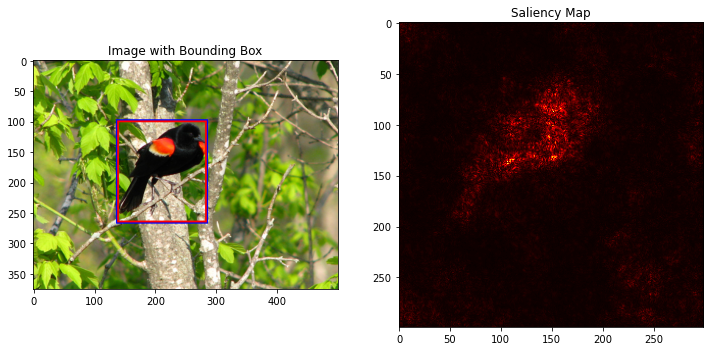

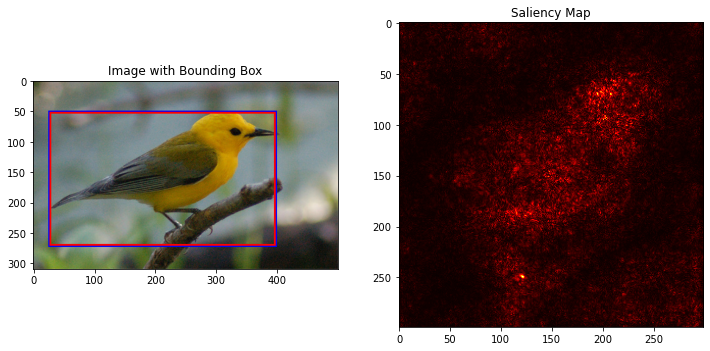

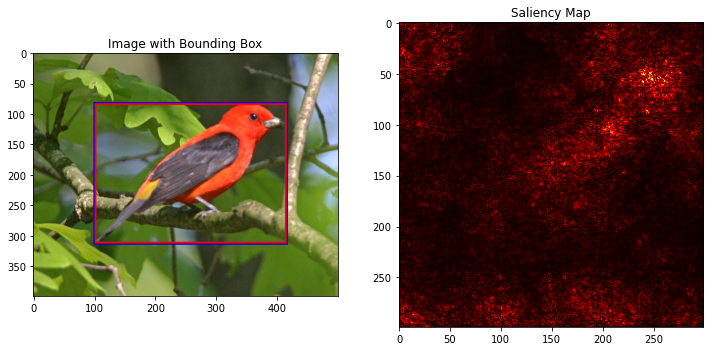

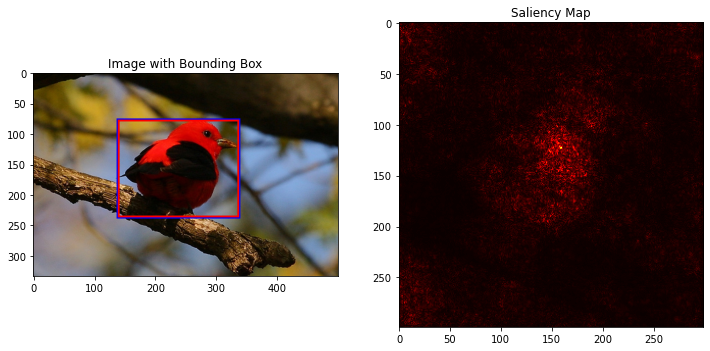

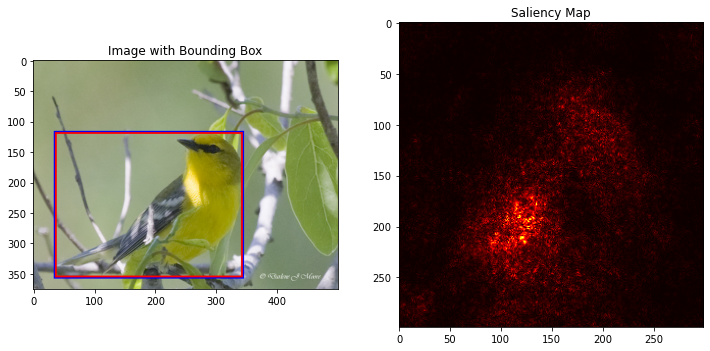

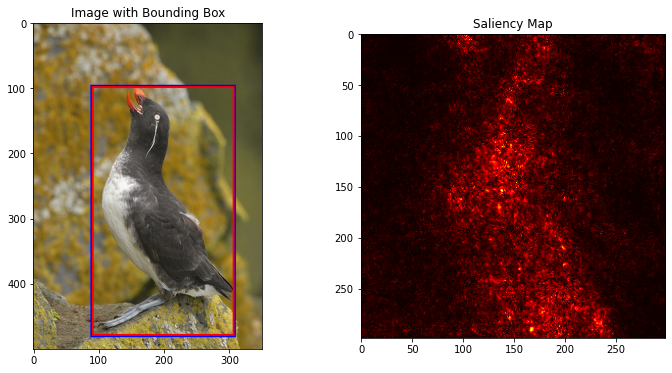

In [73]:
def plot_image_with_bbox_and_saliency_map(test_image_df, PATH_saliency_maps):
    
    # Load saliency maps 
    saliency_maps = np.load(PATH_saliency_maps)
        
    for i in range(len(test_image_df)):
        
        # Load the image
        image = Image.open(test_image_df['full_path'][i])
        
        # Saliency maps
        saliency_map = saliency_map = saliency_maps[:,:,i]

        # Create a draw object
        draw = ImageDraw.Draw(image)
        bounding_box = test_image_df['bounding_box'][i]
        bounding_box = list(map(int,bounding_box))

        # Draw the bounding box on the image
        draw.rectangle(bounding_box, outline='red', width=5)


        # Draw a rectangle to highlight the intersection area
        draw.rectangle(bounding_box, outline='blue', width=2, fill=None)
        draw.rectangle(bounding_box, outline='blue', width=2)

        plt.figure(figsize=(12, 6))
        # Plot the image with the bounding box and saliency map
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title('Image with Bounding Box')

        plt.subplot(1, 2, 2)
        plt.imshow(saliency_map, cmap='hot')
        plt.title('Saliency Map')

        plt.show()

plot_image_with_bbox_and_saliency_map(test_image_df, PATH_saliency_maps)

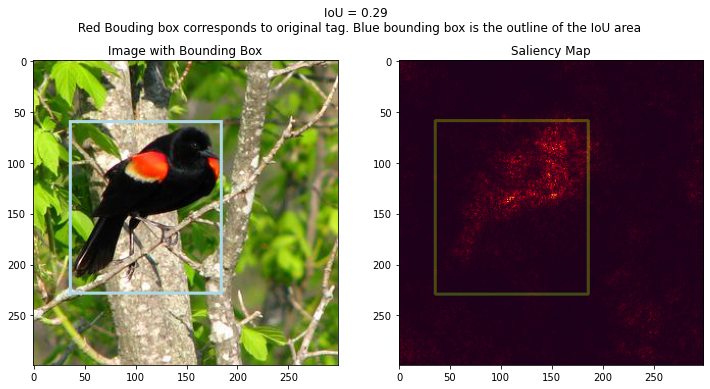

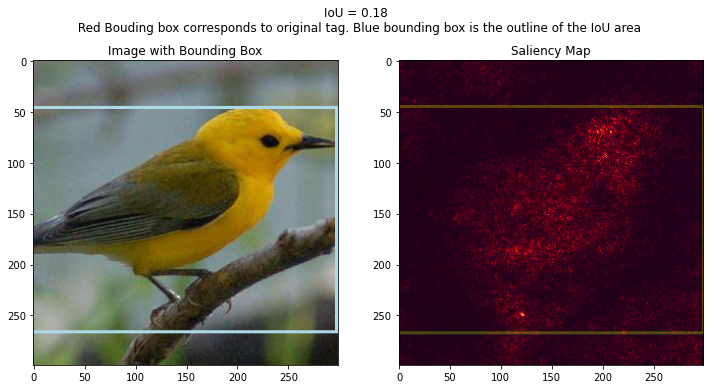

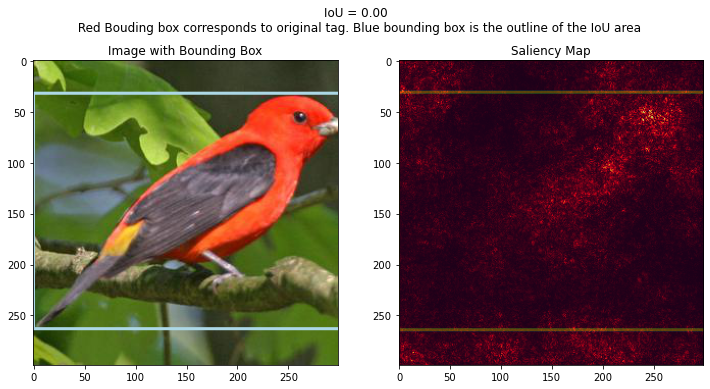

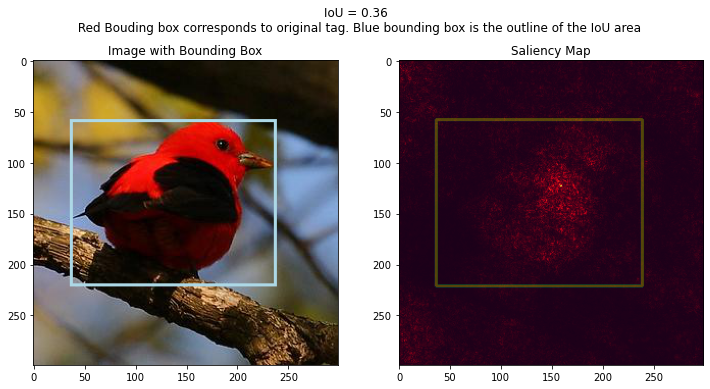

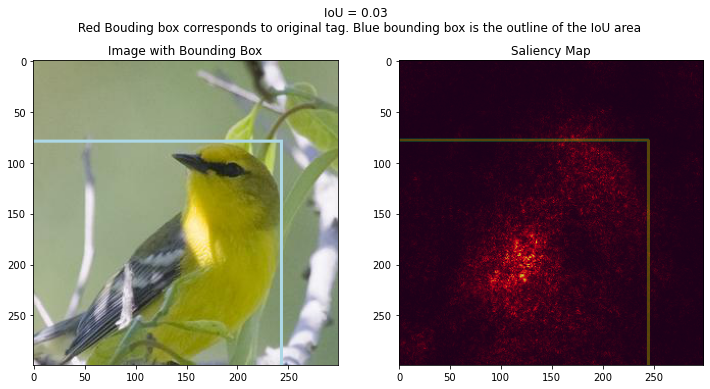

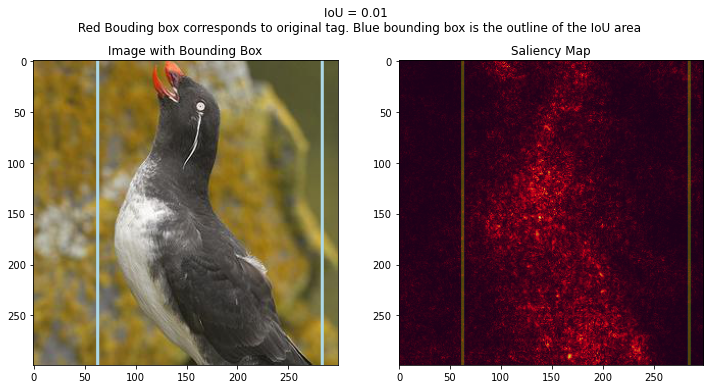

In [74]:
def plot_image_with_bbox_and_saliency_map(test_image_df, PATH_saliency_maps, iou_values):
    # Load saliency maps
    saliency_maps = np.load(PATH_saliency_maps)
    
    for i in range(len(test_image_df)):
        # Load the image
        image = Image.open(test_image_df['cropped_image_path'][i])
        
        # Saliency maps
        saliency_map = saliency_maps[:,:,i]

        # Create a draw object
        draw = ImageDraw.Draw(image)
        bounding_box = 0
        bounding_box = test_image_df['new_bbox'][i]
        bounding_box = list(map(int, bounding_box))

        # Draw the bounding box on the image
        draw.rectangle(bounding_box, outline='lightblue', width=3)
 
        # Draw the bounding box on the saliency map
        saliency_map_with_bbox = saliency_map.copy()
        x1, y1, x2, y2 = bounding_box
        cv2.rectangle(saliency_map_with_bbox, (x1, y1), (x2, y2), (255, 0, 0), 2)

        plt.figure(figsize=(12, 6))
        # Plot the image with the bounding box and saliency map
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title('Image with Bounding Box')

        plt.subplot(1, 2, 2)
        plt.imshow(saliency_map, cmap='hot')
        plt.imshow(saliency_map_with_bbox, alpha=0.3)
        plt.title('Saliency Map')

        # Add a text label for the IoU
        plt.suptitle(f'IoU = {iou_values[i]:.2f} \n Red Bouding box corresponds to original tag. Blue bounding box is the outline of the IoU area')

        plt.show()
        
        # Clear variables
        del image, saliency_map, draw, bounding_box, saliency_map_with_bbox
        

plot_image_with_bbox_and_saliency_map(test_image_df, PATH_saliency_maps, iou_values)


### Saliency maps (most salient pixels) vs true part location

> Part names, part locations and if they are visible

In [75]:
# Load the parts data
parts_df = pd.read_csv('/Users/lucialarraona/Desktop/responsibleai/ConceptBottleneck/CUB/CUB_200_2011/CUB_200_2011/parts/part_locs.txt', sep=' ', header=None, names=['image_id', 'part_id', 'x', 'y', 'visible'])

# Load the part names
with open('/Users/lucialarraona/Desktop/responsibleai/ConceptBottleneck/CUB/CUB_200_2011/CUB_200_2011/parts/parts.txt', 'r') as f:
    part_names = {int(line.split()[0]): line.split()[1] for line in f.readlines()}

# Merge the parts data with test_image_df
test_image_df = test_image_df.merge(parts_df, left_on='id', right_on='image_id',how='left')

# Add the part name column
test_image_df['part_name'] = test_image_df['part_id'].map(part_names)

# Add the part_location column
test_image_df['part_location'] = list(zip(test_image_df['x'], test_image_df['y']))


In [76]:
test_image_df.head(1)

id                                          file_path  \
0  508  010.Red_winged_Blackbird/Red_Winged_Blackbird_...   

                                           full_path  \
0  /Users/lucialarraona/Desktop/responsibleai/Con...   

                          info                 bounding_box  \
0  [136.0, 97.0, 150.0, 170.0]  [136.0, 97.0, 286.0, 267.0]   

                                    attribute_vector  \
0  [0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, ...   

                                      top_attributes  \
0  [179 has_under_tail_color::black, 146 has_eye_...   

                                  cropped_image_path  \
0  /Users/lucialarraona/XAI_project/cropped_image...   

                     new_bbox  image_id  part_id      x      y  visible  \
0  (35.5, 59.0, 185.5, 229.0)       508        1  222.0  119.0        1   

  part_name   part_location  
0      back  (222.0, 119.0)

In [77]:
# Recalculate the part locations for the cropped images, and eliminate the ones that are negative for further
# plotting

def calculate_new_partlocations(part_location, crop_size, image_filename):
    # Define the PyTorch transform
    transform = transforms.Compose([
        transforms.CenterCrop(crop_size),
    ])
    # Load the image
    image_np = cv2.imread(image_filename)
    image = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(image)

    # Apply the transform to the image and get the cropped image
    cropped_image = transform(image)
    # Calculate the center of the original image
    original_center = (image_np.shape[1] / 2, image_np.shape[0] / 2)
   
    # Calculate the center of the cropped region
    crop_center = (crop_size / 2, crop_size / 2)
   
    # Calculate the new coordinates of the object in the cropped region
    part_location = (
        part_location[0] - original_center[0] + crop_center[1],
        part_location[1] - original_center[1] + crop_center[0],
    )
   
    return part_location

part_locations = test_image_df['part_location'].tolist()
image_paths = test_image_df['full_path'].tolist()
new_part_locations = []

for part_location, image_path in zip(part_locations, image_paths):
    new_part_location = calculate_new_partlocations(part_location=part_location, crop_size=299, image_filename=image_path)
    new_part_locations.append(new_part_location)
    
#Apply the function
test_image_df['new_part_location'] = new_part_locations


def eliminate_negative_new_partlocations(new_part_location):
    # Check if the new part location has negative values, and set them to 0
    new_part_location = (max(0, new_part_location[0]), max(0, new_part_location[1]))
    return new_part_location

# Apply the function to the part_location column and create a new column with the results
test_image_df['new_part_location_2'] = test_image_df['new_part_location'].apply(eliminate_negative_new_partlocations)

In [78]:
test_image_df.head(1)

id                                          file_path  \
0  508  010.Red_winged_Blackbird/Red_Winged_Blackbird_...   

                                           full_path  \
0  /Users/lucialarraona/Desktop/responsibleai/Con...   

                          info                 bounding_box  \
0  [136.0, 97.0, 150.0, 170.0]  [136.0, 97.0, 286.0, 267.0]   

                                    attribute_vector  \
0  [0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, ...   

                                      top_attributes  \
0  [179 has_under_tail_color::black, 146 has_eye_...   

                                  cropped_image_path  \
0  /Users/lucialarraona/XAI_project/cropped_image...   

                     new_bbox  image_id  part_id      x      y  visible  \
0  (35.5, 59.0, 185.5, 229.0)       508        1  222.0  119.0        1   

  part_name   part_location new_part_location new_part_location_2  
0      back  (222.0, 119.0)     (121.5, 81.0)       (121.5, 81.0)

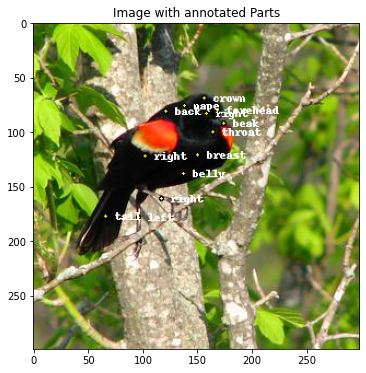

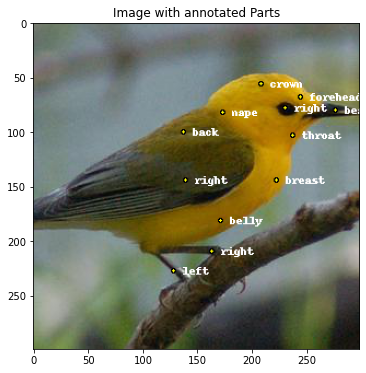

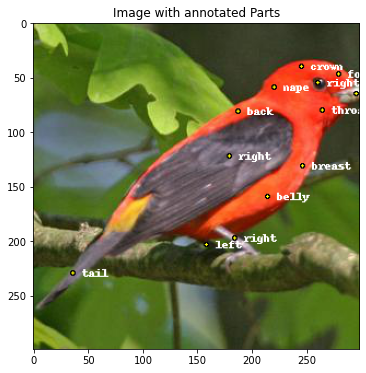

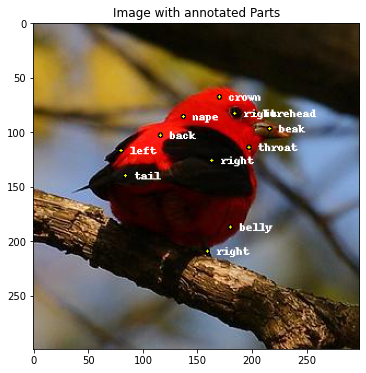

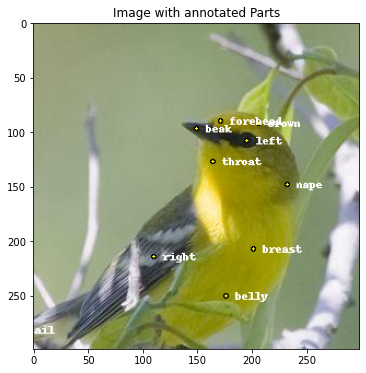

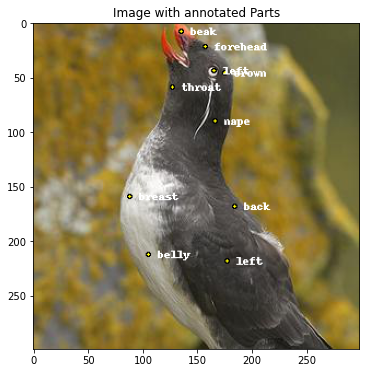

In [79]:
image_ids = list(test_image_df['id'].unique())

for image_id in image_ids:

    # Load the image
    image = Image.open(test_image_df[test_image_df['id'] == image_id]['cropped_image_path'].values[0])

    # Load the bounding box
    x1, y1, x2, y2 = test_image_df[test_image_df['id'] == image_id]['new_bbox'].values[0]

    # Calculate the coordinates of the top-left corner of the cropped image
    left = x1
    top = y1

    # Load the part locations for this image
    part_locations = test_image_df[test_image_df['id'] == image_id][['part_name', 'new_part_location']]
    
    # Draw circles around the relocated part locations on the cropped image
    draw = ImageDraw.Draw(image)
    for i in range(len(part_locations)):
        x, y = part_locations.iloc[i]['new_part_location']
        draw.ellipse([x-2, y-2, x+2, y+2], fill='yellow', outline='black')
        draw.text([x+9, y-5], part_locations.iloc[i]['part_name'], fill='white')


    # Display the cropped image with the relocated part locations
    plt.figure(figsize=(12, 6))
    plt.imshow(image)
    plt.title('Image with annotated Parts')
    plt.show()

- **Checking if the part locations fall within the saliency map bounds:**

    *This code checks whether the x and y coordinates of each part location are within the bounds of the saliency map, and increments the count if they are. Note that we check that x is between 0 and the width of the saliency map (which is the second element of saliency_map_shape), and that y is between 0 and the height of the saliency map (which is the first element of saliency_map_shape).*

In [80]:
# Load the saliency map
saliency_maps = np.load(PATH_saliency_maps)

for i,image_id in enumerate(image_ids):
    
    saliency_map_shape = saliency_maps[:,:,i].shape
    
    num_part_locations_within_saliency_map = 0

    for location in test_image_df[test_image_df['id'] == image_id]['new_part_location_2'].to_list():
        x, y = location
        if x >= 0 and x < saliency_map_shape[1] and y >= 0 and y < saliency_map_shape[0]:
            num_part_locations_within_saliency_map += 1

    print(num_part_locations_within_saliency_map)

15
15
15
15
15
13


- **Checking if the part locations are not only within the saliency map bounds, but also if they are close to the most salient pixels**

*In this example, we load the saliency map and part locations. We then find the location of the most salient pixel(s) in the saliency map by using the np.argwhere function to get the indices of the maximum values in the saliency map, and then calculate the mean location of these indices. We then calculate the distance between each part location and the most salient pixel(s) using the np.linalg.norm function, and finally check which part locations are close enough to the most salient pixel(s) by using a threshold distance. The result is a list of part locations that are close enough to the most salient pixel(s).*

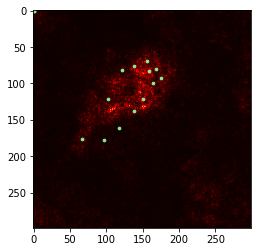

For image 508, 66.67% of part locations are close to the most salient pixels.


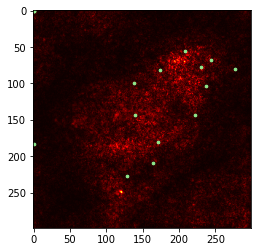

For image 10422, 26.67% of part locations are close to the most salient pixels.


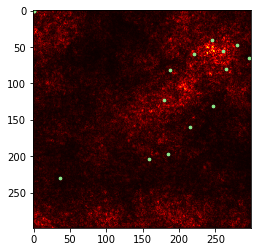

For image 8159, 26.67% of part locations are close to the most salient pixels.


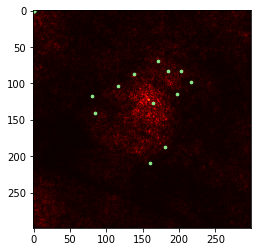

For image 8139, 13.33% of part locations are close to the most salient pixels.


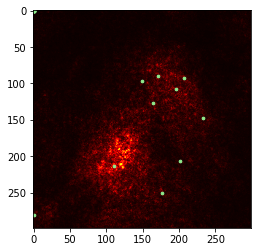

For image 9455, 26.67% of part locations are close to the most salient pixels.


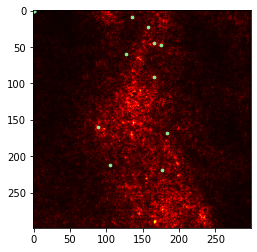

For image 340, 7.69% of part locations are close to the most salient pixels.


In [81]:
image_ids = list(test_image_df['id'].unique())

# Set the threshold distance for a part location to be considered close to the most salient pixel
threshold = 50 # in pixels

# Set the threshold for salient pixels to be considered
salient_threshold = 0.95

# Create a figure to hold the saliency map and part locations
fig, ax = plt.subplots()

# Loop over the test images
for i,image_id in enumerate(image_ids):

    # Load the saliency map
    saliency_maps = np.load(PATH_saliency_maps)
    saliency_map = saliency_maps[:,:,i]

    # Get the indices of the salient pixels
    salient_pixels = np.argwhere(saliency_map >= np.max(saliency_map) * salient_threshold)

    # Load the part locations
    part_locations = test_image_df[test_image_df['id'] == image_id]['new_part_location_2'].to_list()
    
    # Filter out part locations that are out of bounds of the saliency map size
    part_locations = [p for p in part_locations if p[0] >= 0 and p[0] < saliency_map.shape[1] and p[1] >= 0 and p[1] < saliency_map.shape[0]]

    # Calculate the Euclidean distance between each part location and the salient pixels
    distances = np.linalg.norm(np.array(part_locations)[:, np.newaxis, :] - np.array(salient_pixels)[np.newaxis, :, :], axis=2)

    # Count the number of part locations that are close to the salient pixels
    num_close_part_locations = np.sum(distances < threshold)

    # Calculate the percentage of part locations that are close to the salient pixels
    percent_close_part_locations = (num_close_part_locations / len(part_locations)) * 100

    
    plt.imshow(saliency_map,cmap='hot')
    plt.scatter(np.array(part_locations)[:,0], np.array(part_locations)[:,1], marker='o', color='lightgreen', s=7)
    plt.show()
    
    print(f"For image {image_id}, {percent_close_part_locations:.2f}% of part locations are close to the most salient pixels.")

### Plot everything together

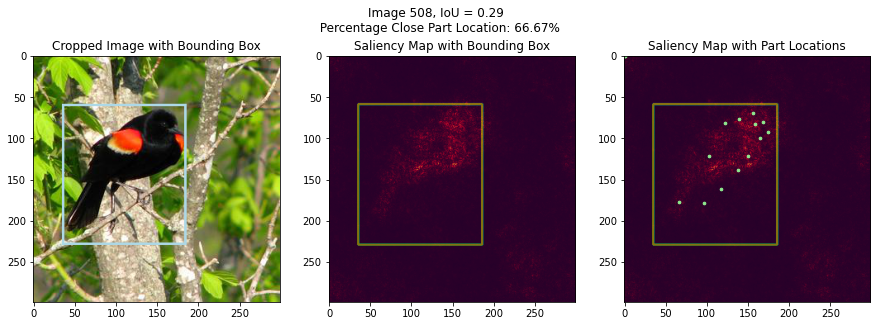

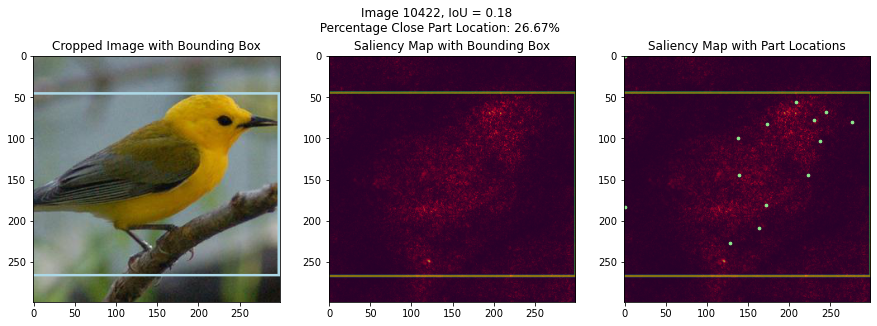

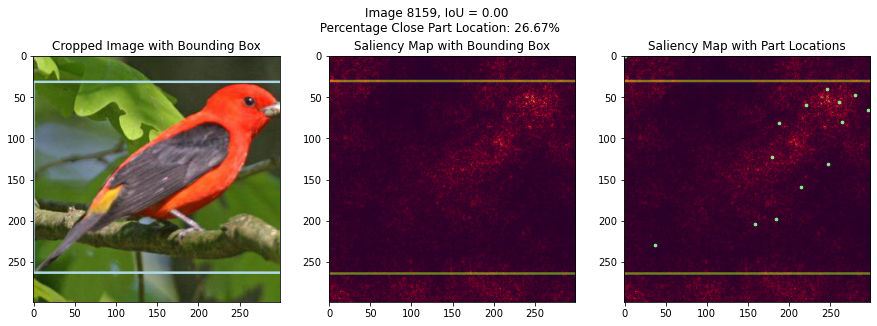

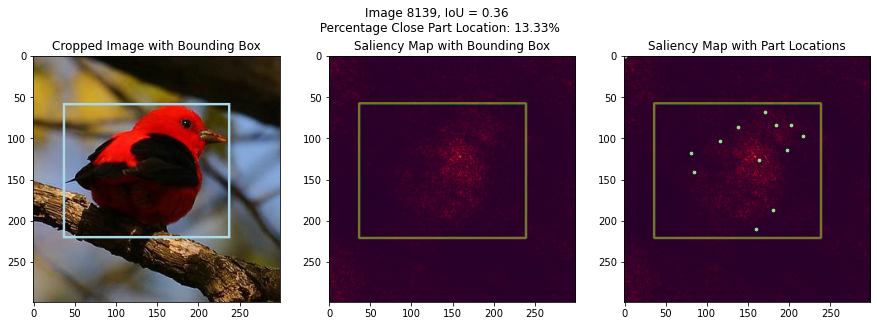

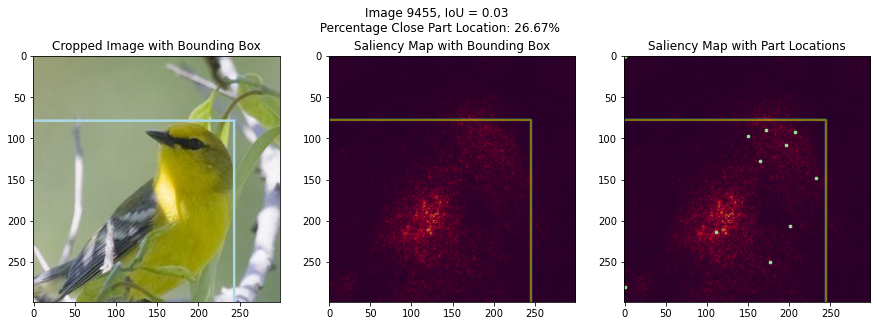

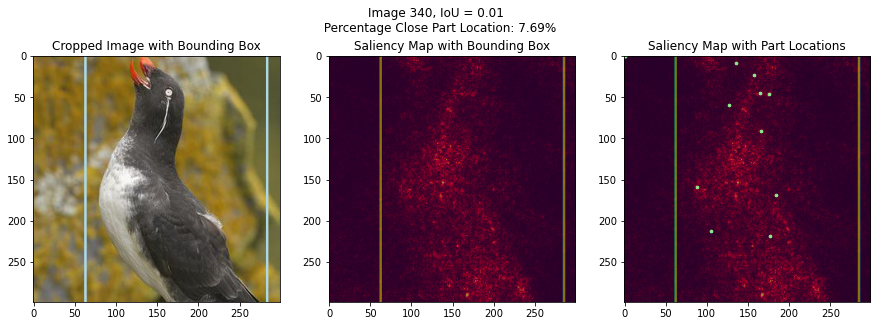

In [82]:
image_ids = list(test_image_df['id'].unique())

# Set the threshold distance for a part location to be considered close to the most salient pixel
threshold = 50 # in pixels

# Set the threshold for salient pixels to be considered
salient_threshold = 0.95


# Loop over the test images
for i, image_id in enumerate(image_ids):

    # Load the image
    image = Image.open(test_image_df[test_image_df['id'] == image_id]['cropped_image_path'].unique()[0])

    # Load the saliency map
    saliency_maps = np.load(PATH_saliency_maps)
    saliency_map = saliency_maps[:,:,i]

    # Get the indices of the salient pixels
    salient_pixels = np.argwhere(saliency_map >= np.max(saliency_map) * salient_threshold)

    # Load the bounding box coordinates
    bounding_box = test_image_df[test_image_df['id'] == image_id]['new_bbox'].unique()[0]
    bounding_box = list(map(int, bounding_box))

    # Load the part locations
    part_locations = test_image_df[test_image_df['id'] == image_id]['new_part_location_2'].to_list()
    
    # Filter out part locations that are out of bounds of the saliency map size
    part_locations = [p for p in part_locations if p[0] >= 0 and p[0] < saliency_map.shape[1] and p[1] >= 0 and p[1] < saliency_map.shape[0]]

    # Calculate the Euclidean distance between each part location and the salient pixels
    distances = np.linalg.norm(np.array(part_locations)[:, np.newaxis, :] - np.array(salient_pixels)[np.newaxis, :, :], axis=2)

    # Count the number of part locations that are close to the salient pixels
    num_close_part_locations = np.sum(distances < threshold)

    # Calculate the percentage of part locations that are close to the salient pixels
    percent_close_part_locations = (num_close_part_locations / len(part_locations)) * 100
    

    
    
    # --------------
    
    # Create a draw object
    draw = ImageDraw.Draw(image)
    # Draw the bounding box on the image
    draw.rectangle(bounding_box, outline='lightblue', width=3)
    
    # Draw the bounding box on the saliency map
    saliency_map_with_bbox = saliency_map.copy()
    x1, y1, x2, y2 = bounding_box
    cv2.rectangle(saliency_map_with_bbox, (x1, y1), (x2, y2), (255, 0, 0), 2)

    
    # Create a figure to hold the subplots
    fig, ax = plt.subplots(1, 3, figsize=(15,5))

    # Plot the cropped image with the bounding box
    ax[0].imshow(image)
    ax[0].set_title('Cropped Image with Bounding Box')

    # Plot the saliency map with the bounding box
    ax[1].imshow(saliency_map, cmap='hot')
    ax[1].imshow(saliency_map_with_bbox, alpha=0.5)
    ax[1].set_title('Saliency Map with Bounding Box')
    
    # Plot the saliency map with the part locations
    ax[2].imshow(saliency_map, cmap='hot')
    ax[2].imshow(saliency_map_with_bbox, alpha=0.5)
    ax[2].set_title('Saliency Map with Part Locations')
    ax[2].scatter(np.array(part_locations)[:,0], np.array(part_locations)[:,1], marker='o', color='lightgreen', s=7)
    
    
    # Set the suptitle of the figure
    fig.suptitle(f'Image {image_id}, IoU = {iou_values[i]:.2f} \n Percentage Close Part Location: {percent_close_part_locations:.2f}%')
    
    plt.savefig(f'{image_id}_saliency_map.png')

### Concepts vs attributes

**IDEA**

In a bottleneck model, the attributes are represented by a low-dimensional feature vector, which is typically much smaller than the input image or object feature vector. This feature vector captures the most important information about the object, and it can be used to recognize or classify the object.

The concepts in a bottleneck model are usually represented by the classes in the final output layer. Each class corresponds to a different concept that the model is trained to recognize. For example, in an image classification model, the classes might correspond to different types of objects or scenes, such as "dog", "cat", "beach", "mountain", etc.

To relate the attributes to the concepts, you can train a classifier on top of the bottleneck features. The classifier can take the bottleneck features as input and output a probability distribution over the different classes. The classifier can be trained using supervised learning on a labeled dataset, where each image is labeled with the correct class. Once the classifier is trained, you can use it to predict the class of new images based on their bottleneck features.

To interpret the learned concepts, you can analyze the weights of the final output layer. Each weight corresponds to a different feature in the bottleneck representation, and the magnitude of the weight indicates how important that feature is for the corresponding class. You can visualize these weights as heatmaps to get an idea of which parts of the object or image are most important for different concepts.

> Print the top 10 attributes corresponding to the image examples

In [84]:
image_ids = list(test_image_df['id'].unique())

for image_id in image_ids:
    image_row = test_image_df[test_image_df['image_id'] == image_id]
    if not image_row.empty:
        top_attributes = image_row['top_attributes'].iloc[0]
        for attribute in top_attributes:
            print(f"Image ID: {image_id}, Attribute: {attribute}")
        print('\n')
    else:
        print(f"No row found for image ID {image_id}")

Image ID: 508, Attribute: 179 has_under_tail_color::black
Image ID: 508, Attribute: 146 has_eye_color::black
Image ID: 508, Attribute: 51 has_underparts_color::black
Image ID: 508, Attribute: 70 has_back_color::black
Image ID: 508, Attribute: 91 has_upper_tail_color::black
Image ID: 508, Attribute: 260 has_primary_color::black
Image ID: 508, Attribute: 132 has_throat_color::black
Image ID: 508, Attribute: 164 has_forehead_color::black
Image ID: 508, Attribute: 305 has_crown_color::black
Image ID: 508, Attribute: 117 has_breast_color::black


Image ID: 10422, Attribute: 55 has_breast_pattern::solid
Image ID: 10422, Attribute: 189 has_nape_color::yellow
Image ID: 10422, Attribute: 255 has_primary_color::yellow
Image ID: 10422, Attribute: 46 has_underparts_color::yellow
Image ID: 10422, Attribute: 204 has_belly_color::yellow
Image ID: 10422, Attribute: 112 has_breast_color::yellow
Image ID: 10422, Attribute: 127 has_throat_color::yellow
Image ID: 10422, Attribute: 300 has_crown_color::yel

## Comprehensibility of explanations provided by each model

This could be assessed through a user study where participants are presented with explanations generated by each model and are asked to rate them based on how understandable they are. We can also use metrics such as reading time or error rates to evaluate the effectiveness of the explanations.

# Comparing the sucess of the two models

To compare the success of the two models, we can conduct a randomized controlled trial where participants are randomly assigned to either the saliency map or concept bottleneck group. Each group would be presented with the same set of input-output pairs and the explanations generated by their respective models. We can then collect data on accuracy and comprehensibility and compare the results between the two groups using statistical tests such as t-tests or ANOVA.